<a href="https://colab.research.google.com/github/s97616s97616/Usual_note/blob/main/Fraud_Detection_in_Insurance_Claims.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import warnings
import numpy as np
import pandas as pd 
import lightgbm as lgb
from datetime import datetime
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, KFold

warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 500)

In [ ]:
api_token = {"username":"watsons","key":"dc7da47ca9aa5e696b65f97c16fd627b"}
import json
import zipfile
import os
if not os.path.exists("/root/.kaggle"):
    os.makedirs("/root/.kaggle")
 
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)
!chmod 600 /root/.kaggle/kaggle.json
 
if not os.path.exists("/kaggle"):
    os.makedirs("/kaggle")
os.chdir('/kaggle')
!kaggle competitions download -c fraud-detection-in-insurance-claims --force
!unzip fraud-detection-in-insurance-claims

In [3]:
file = pd.read_csv('train.csv')

In [4]:
file.shape

(700, 40)

In [5]:
cont = ['months_as_customer', 'age', 'policy_annual_premium', 'total_claim_amount', 'injury_claim', 'property_claim', 'vehicle_claim',
'capital-gains', 'capital-loss', 'capital', 'date_diff']

In [6]:
cate = ['policy_state', 'policy_csl', 'policy_deductable', 'umbrella_limit_indicator', 'insured_sex', 'insured_education_level', 'insured_occupation'
, 'insured_hobbies', 'insured_relationship', 'incident_type', 'collision_type', 'incident_severity', 'authorities_contacted', 'incident_state'
, 'incident_city', 'incident_hour_of_the_day', 'number_of_vehicles_involved', 'property_damage', 'bodily_injuries', 'witnesses', 'police_report_available'
, 'auto_make', 'auto_model', 'auto_year', 'capital_gains_indicator', 'capital_indicator']

In [7]:
file['policy_bind_date'] = [datetime.strptime(x, "%Y-%m-%d") for x in file['policy_bind_date']]
file['incident_date'] = [datetime.strptime(x, "%Y-%m-%d") for x in file['incident_date']]
file['date_diff'] = file['incident_date'] - file['policy_bind_date']
file['date_diff'] = [x.days for x in file['date_diff']]

file['umbrella_limit_indicator'] = 0
file.loc[file['umbrella_limit'] != 0, 'umbrella_limit_indicator'] = 1

file['capital'] = file['capital-gains'] - file['capital-loss']

file['capital_indicator'] = 0
file.loc[file['capital'] != 0, 'capital_indicator'] = 1

file['capital_gains_indicator'] = 0
file.loc[file['capital-gains'] != 0, 'capital_gains_indicator'] = 1

file['capital_loss_indicator'] = 0
file.loc[file['capital-loss'] != 0, 'capital_loss_indicator'] = 1


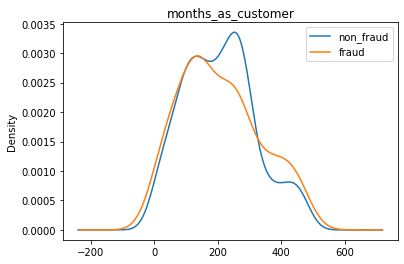

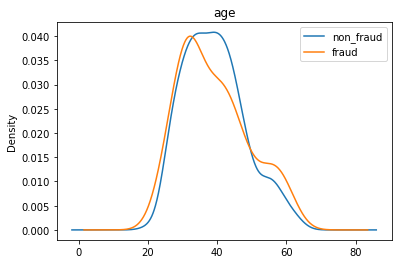

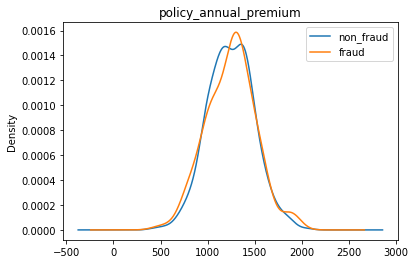

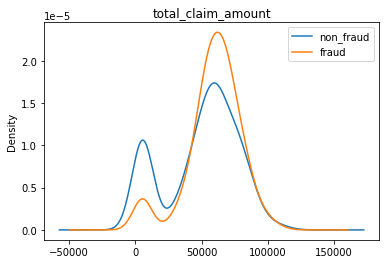

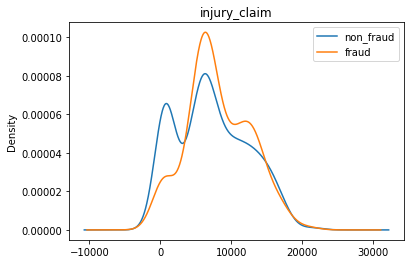

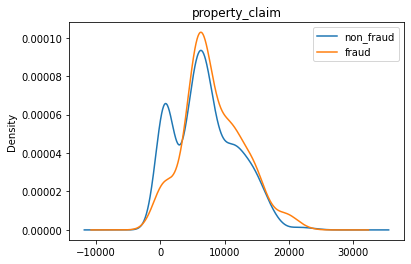

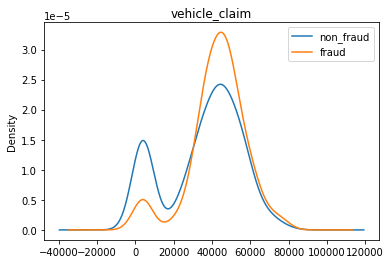

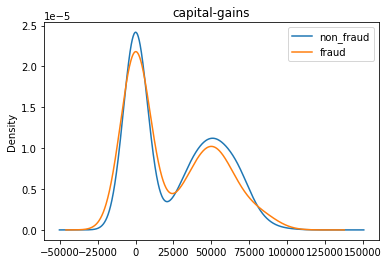

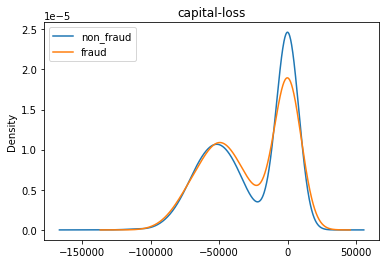

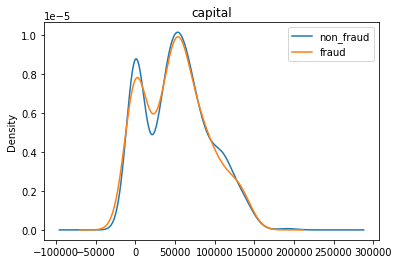

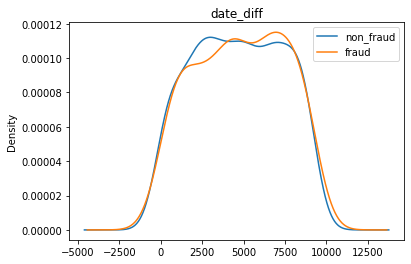

In [8]:
for col in cont:  
  temp_0 = np.array(file.loc[file['fraud_reported'] == 0, col])
  temp_1 = np.array(file.loc[file['fraud_reported'] == 1, col])
  temp_con = pd.DataFrame([temp_0, temp_1]).T
  temp_con.columns = ['non_fraud', 'fraud']
  temp_con.plot(kind = 'kde', title = col)

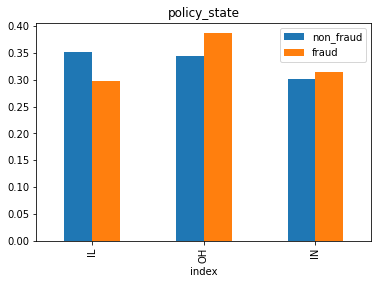

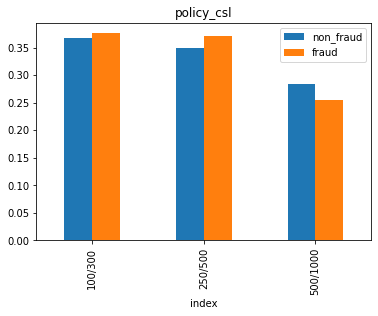

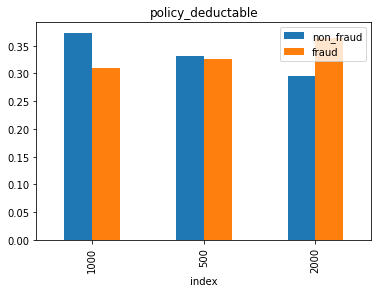

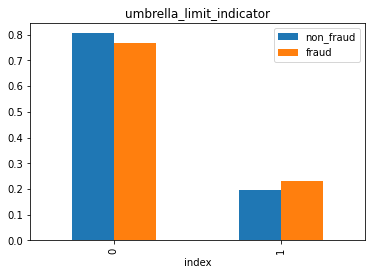

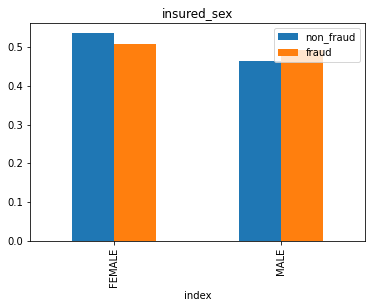

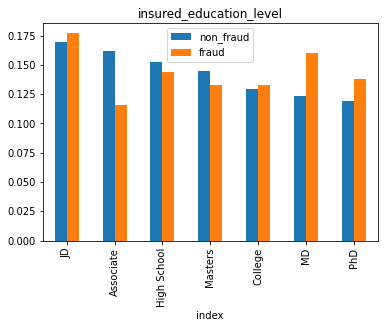

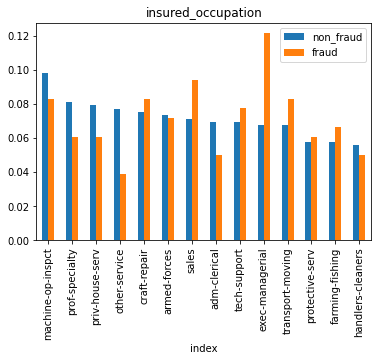

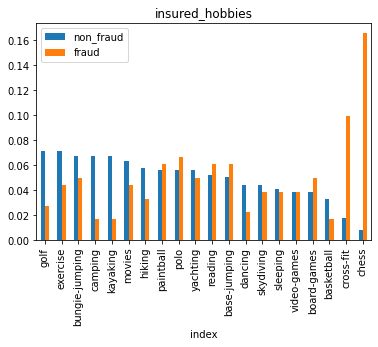

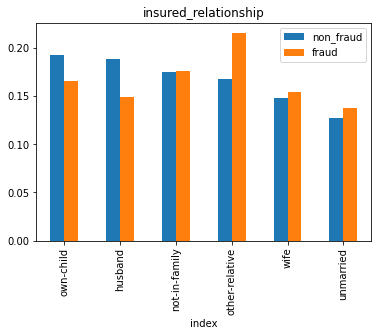

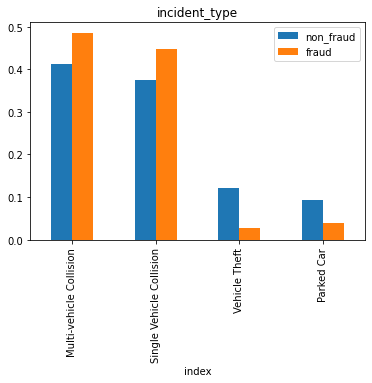

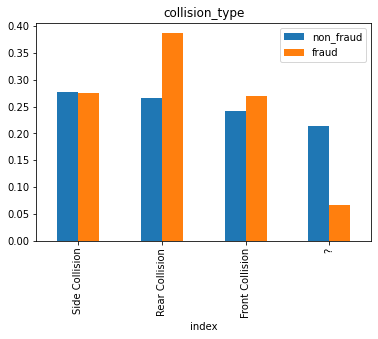

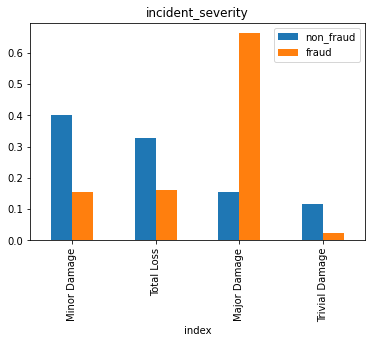

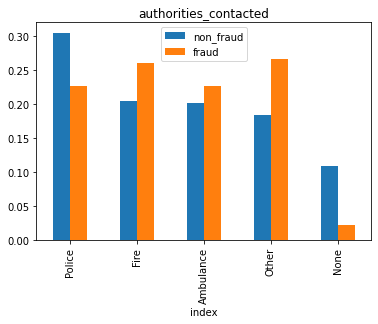

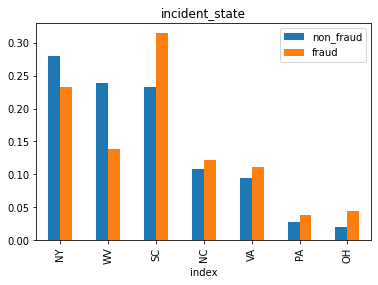

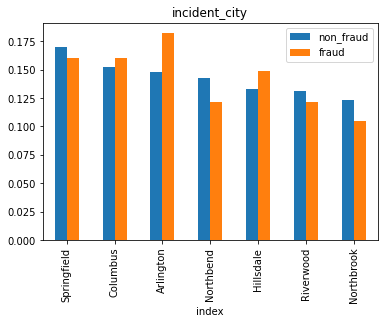

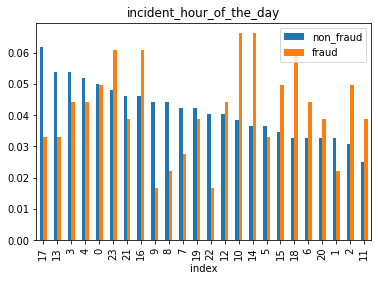

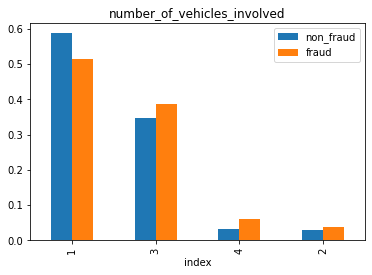

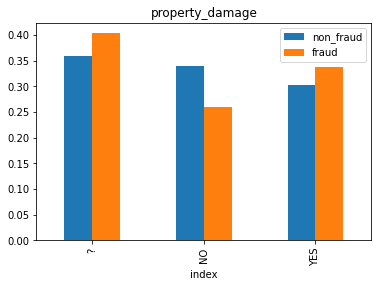

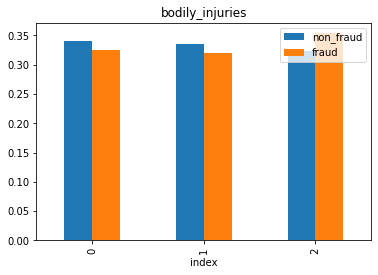

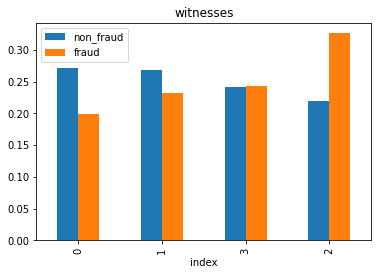

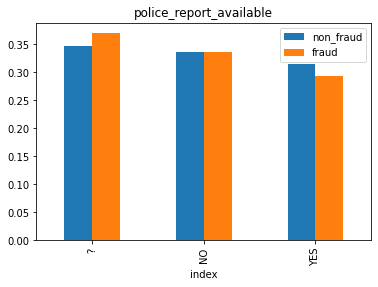

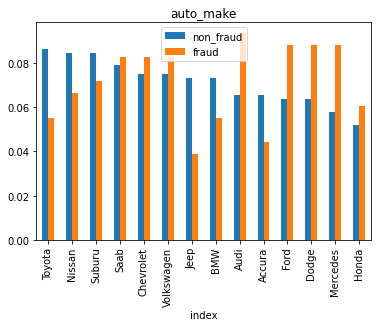

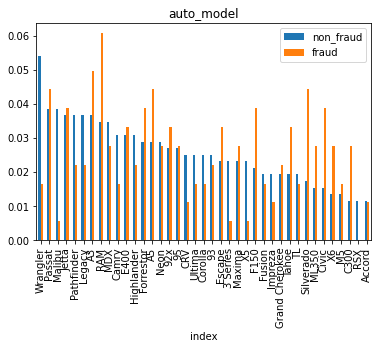

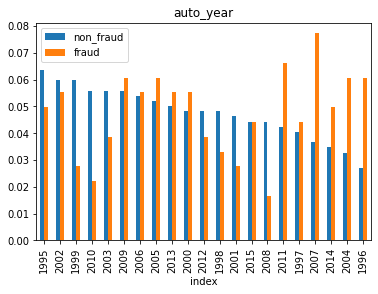

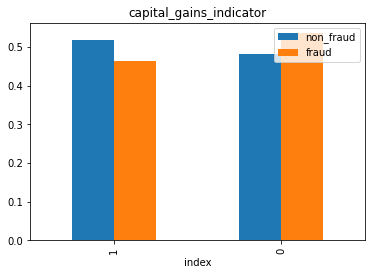

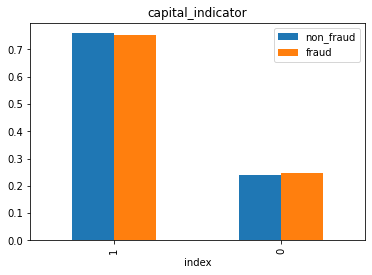

In [9]:
for col in cate:
  temp_0 = pd.DataFrame(file.loc[file['fraud_reported'] == 0, col].value_counts(normalize = True))
  temp_0.reset_index(inplace = True)
  temp_1 = pd.DataFrame(file.loc[file['fraud_reported'] == 1, col].value_counts(normalize = True))
  temp_1.reset_index(inplace = True)
  temp = temp_0.merge(temp_1, on = 'index', how = 'outer')
  temp.set_index('index', inplace = True)
  temp.columns = ['non_fraud', 'fraud']
  temp.plot.bar(title = col)

In [10]:
for var in cate:
  file[var] = preprocessing.LabelEncoder().fit_transform(file[var])

for var in cont:
  file[var] = preprocessing.scale(file[var])

In [11]:
y = file['fraud_reported']
x = file[cont + cate]

In [12]:
round(cross_val_score(lgb.LGBMClassifier(), x, y, cv = 5, scoring = 'roc_auc').mean(), 3)

0.824

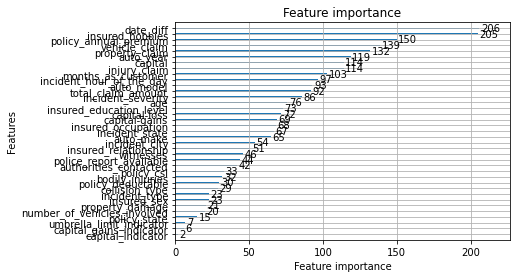

In [13]:
model = lgb.LGBMClassifier().fit(x, y)
lgb.plot_importance(model)

In [14]:
feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_, x.columns), reverse = True), columns=['Value','Feature'])
x_selected = x[feature_imp['Feature'][:15]]

In [15]:
round(cross_val_score(lgb.LGBMClassifier(), x_selected, y, cv = 5, scoring = 'roc_auc').mean(), 3)

0.834